In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from PIL import Image
from tqdm.notebook import trange, tqdm

import numpy as np
import matplotlib.pyplot as plt

import json
import os
import random

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
torch.cuda.is_available()

True

In [4]:
# Check if CUDA is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

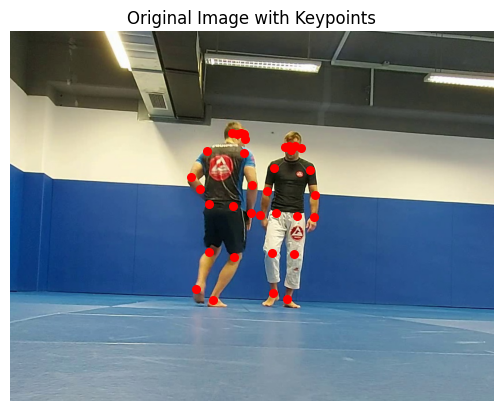

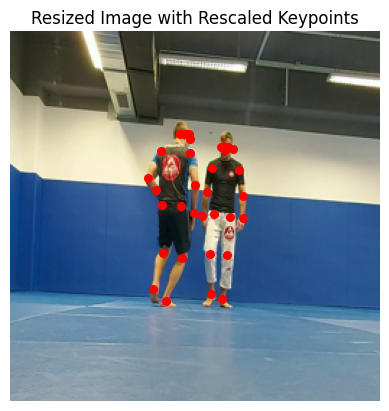

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

"""
This code proves concept what rescaled keypoints coordinates works just fine on rescaled image.
"""

def resize_image_and_annotations(image, keypoints, new_size=(256, 256)):
    # Original image size
    w_old, h_old = image.size
    
    # Resize image
    resized_image = image.resize(new_size)
    
    # Rescale keypoints
    scale_x = new_size[0] / w_old
    scale_y = new_size[1] / h_old
    keypoints_rescaled = [(x * scale_x, y * scale_y) for x, y, _ in keypoints]
    
    return resized_image, keypoints_rescaled


def plot_image_with_keypoints(image, keypoints, title=''):
    plt.imshow(image)
    keypoints = np.array(keypoints)
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=30)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load an example image
image_path = '/home/aistation/Downloads/pose.jpg'
image = Image.open(image_path)

# Example annotations (keypoints) - [(x, y) coordinates]
keypoints = [[500.49737548828125, 228.51727294921875, 0.9495455026626587], [493.35528564453125, 216.8970947265625, 0.9346149563789368], [499.60162353515625, 217.62896728515625, 0.9109803438186646], [473.63580322265625, 216.68353271484375, 0.8858197927474976], [483.81744384765625, 218.14520263671875, 0.8883137702941895], [420.02008056640625, 254.29736328125, 1.0347471237182617], [499.90509033203125, 258.25018310546875, 0.9103400707244873], [384.88726806640625, 311.08001708984375, 0.8736821413040161], [515.7789916992188, 326.6981201171875, 0.9337013959884644], [405.16021728515625, 336.12164306640625, 0.7191264629364014], [512.9671020507812, 386.25372314453125, 1.0423088073730469], [424.00872802734375, 368.52447509765625, 0.8987381458282471], [475.34246826171875, 371.49078369140625, 0.8884949684143066], [424.93170166015625, 470.61993408203125, 0.9208459854125977], [477.49322509765625, 481.739013671875, 0.8854950666427612], [396.33258056640625, 548.4592895507812, 0.8148304224014282], [433.05645751953125, 573.02734375, 0.925529956817627], [599.4434814453125, 252.10018920898438, 0.9374439716339111], [607.8125, 244.96572875976562, 0.9288402795791626], [594.496337890625, 243.51882934570312, 0.8707908391952515], [620.6929931640625, 248.45974731445312, 0.9529407024383545], [587.2814331054688, 245.58358764648438, 0.9028269052505493], [639.3309326171875, 294.6269226074219, 0.966119647026062], [563.4530639648438, 290.5401306152344, 0.9489667415618896], [649.593505859375, 349.4287414550781, 1.0114314556121826], [548.7277221679688, 341.0274963378906, 0.9734671115875244], [648.0433349609375, 396.0214538574219, 1.0410786867141724], [533.3141479492188, 391.8768005371094, 0.7355667352676392], [612.797119140625, 394.4998474121094, 0.9600510001182556], [567.3445434570312, 387.6856994628906, 1.0213289260864258], [605.7802734375, 475.3846740722656, 0.7997826337814331], [558.3246459960938, 473.0023498535156, 0.9746084213256836], [590.3665771484375, 570.6661376953125, 0.9072811603546143], [560.6729125976562, 558.90576171875, 0.6634093523025513]]  # Replace with your actual keypoints

# Plot original image with keypoints
plot_image_with_keypoints(image, keypoints, title="Original Image with Keypoints")

# Resize image and rescale annotations
resized_image, resized_keypoints = resize_image_and_annotations(image, keypoints, new_size=(256, 256))

# Plot resized image with resized keypoints
plot_image_with_keypoints(resized_image, resized_keypoints, title="Resized Image with Rescaled Keypoints")


In [6]:
class BJJPositionDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size
        
        with open(annotation_file) as f:
            self.annotations = json.load(f)

        random.shuffle(self.annotations)
        
        # Get positions of every annotation
        self.positions = [ann['position'] for ann in self.annotations]
        
        self.image_names = [ann['image'] for ann in self.annotations]
        
        self.keypoints1 = []
        self.keypoints2 = []
        
        for ann in self.annotations:
            # The poses of the athletes are in MS-COCO format
            pose1 = ann.get('pose1', [[0, 0, 0]]*17)
            pose2 = ann.get('pose2', [[0, 0, 0]]*17)

            # Use only x,y coordinates, for now skip confidence detector
            self.keypoints1.append([kp[:2] for kp in pose1])
            self.keypoints2.append([kp[:2] for kp in pose2])

        # Map to store position to its label
        self.position_to_label = {
            'standing': 0,
            'takedown1': 1, 
            'takedown2': 2,
            'open_guard1': 3,
            'open_guard2': 4,
            'half_guard1': 5, 
            'half_guard2': 6,
            'closed_guard1': 7,
            'closed_guard2': 8,
            '5050_guard': 9,
            'side_control1': 10,
            'side_control2': 11,
            'mount1': 12, 
            'mount2': 13,
            'back1': 14, 
            'back2': 15,
            'turtle1': 16, 
            'turtle2': 17
        }

        # reverse map of positions
        self.label_to_position = {v: k for k, v in self.position_to_label.items()}
    
    def __len__(self):
        return len(self.annotations)
    
    def rescale_keypoints(self, keypoints, original_width, original_height):
        """Rescale the keypoints to the target image size."""
        scale_x = self.target_size[0] / original_width
        scale_y = self.target_size[1] / original_height
        rescaled_keypoints = []
        for kp in keypoints:
            x_rescaled = kp[0] * scale_x
            y_rescaled = kp[1] * scale_y
            rescaled_keypoints.append([x_rescaled, y_rescaled])
        return rescaled_keypoints
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_names[idx] + '.jpg')
        image = Image.open(img_name).convert('RGB')
        
        # Get original dimensions from the image
        original_width, original_height = image.size
        
        # Resize image to the target size
        if self.transform:
            image = self.transform(image)

        # Rescale keypoints to match the new image size (256x256)
        keypoints1 = self.rescale_keypoints(self.keypoints1[idx], original_width, original_height)
        keypoints2 = self.rescale_keypoints(self.keypoints2[idx], original_width, original_height)

        # Flatten coordinates to 1D list
        keypoints1_flat = [coord for kp in keypoints1 for coord in kp]
        keypoints2_flat = [coord for kp in keypoints2 for coord in kp]

        # Ensure keypoints are the correct length
        required_length = 34
        assert len(keypoints1_flat) == required_length
        assert len(keypoints2_flat) == required_length
        
        keypoints = np.array(keypoints1_flat + keypoints2_flat)
        keypoints = torch.tensor(keypoints, dtype=torch.float32)
        
        # Get label for the position
        label = self.position_to_label[self.positions[idx]]
        label = torch.tensor(label, dtype=torch.long)
        
        # Move keypoints and label to the specified device
        return image, keypoints, label

In [7]:
def calculate_std_and_mean(dataset, device='cuda'):
    l = len(dataset)
    mean, std = 0.0, 0.0

    # Add tqdm progress bar
    for i, _, _ in tqdm(dataset, desc="Calculating mean and std", total=l):
        # Move the image tensor to the GPU
        img = i.float().to(device)
        
        # Calculate mean and std for the current image
        mean += img.mean().item()  # .item() moves the value back to CPU as a float
        std += img.std().item()
    
    # Calculate the final mean and std
    mean /= l
    std /= l
    
    return mean, std


In [8]:
# Here we load our dataset and transform it in order to calculate mean and standart deviation
# of all dataset

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.ToTensor(),          # Convert image to tensor
])

image_dir = '/home/aistation/mybjj/classifier/assets/images'
annotation_file = '/home/aistation/mybjj/classifier/assets/annotations.json'

# Create the dataset without normalization (transform=None or other transforms)
train_dataset = BJJPositionDataset(image_dir, annotation_file, transform=transform)
print(f'Number of testing examples: {len(train_dataset)}')

mean, std = calculate_std_and_mean(train_dataset)
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Number of testing examples: 120279


Calculating mean and std:   0%|          | 0/120279 [00:00<?, ?it/s]

Calculated mean: 0.42640511379656704
Calculated std: 0.2448158246877738


In [9]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize image to 256x256
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[mean], std=[std]),
])

In [10]:
train_dataset = BJJPositionDataset(image_dir, annotation_file, transform=train_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


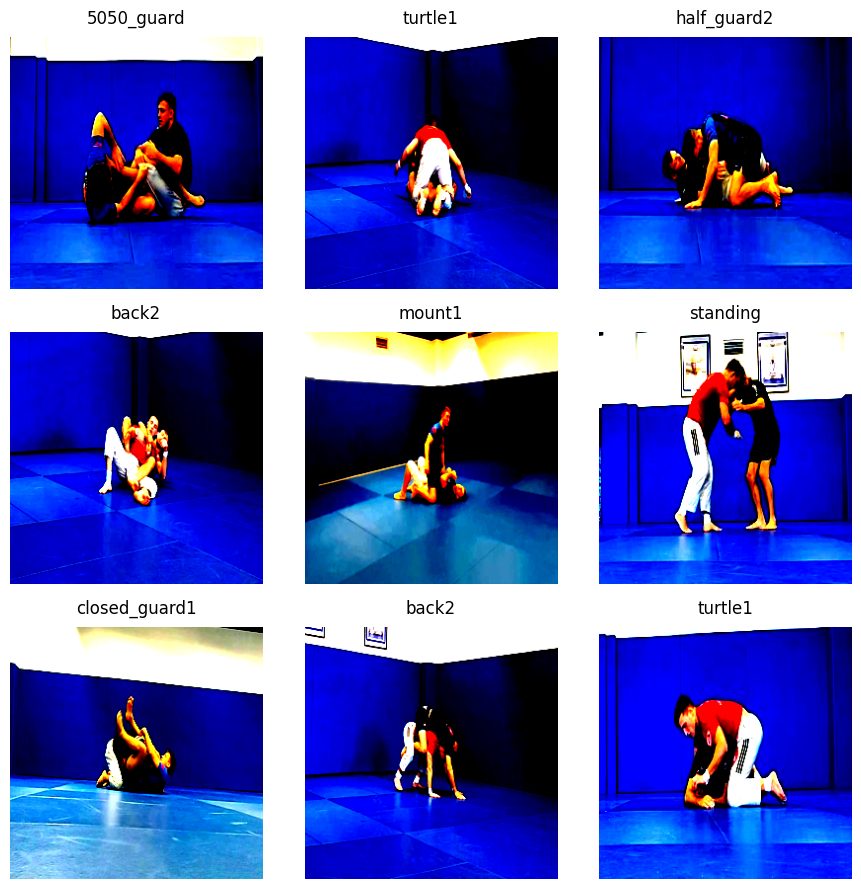

In [11]:
def plot_images(images, labels):
    n_images = len(images)
    
    # Determine grid size: use rows*cols >= n_images
    rows = int(np.ceil(np.sqrt(n_images)))  # Adjust rows to fit all images
    cols = int(np.ceil(n_images / rows))    # Adjust cols accordingly

    fig = plt.figure(figsize=(cols * 3, rows * 3))  # Adjust figure size
    
    for i in range(n_images):
        ax = fig.add_subplot(rows, cols, i + 1)
        
        # If the tensor has 3 channels (RGB), permute it to [H, W, C] for displaying
        image = images[i].permute(1, 2, 0)  # Convert [C, H, W] to [H, W, C]
        ax.imshow(image.cpu().numpy(), cmap='bone')

        # Add the label above the image
        ax.set_title(train_dataset.label_to_position[labels[i].item()], fontsize=12, pad=10)  # Adjust label size and padding
        ax.axis('off')

    plt.tight_layout()  # Automatically adjust spacing
    plt.show()



N_EXAMPLES = 9

IMAGE, KEYPOINT, LABEL = 0, 1, 2

images = [train_dataset[i][IMAGE] for i in range(N_EXAMPLES)]
labels = [train_dataset[i][LABEL] for i in range(N_EXAMPLES)] 

plot_images(images, labels)

In [12]:
VALID_RATIO = 0.8

n_examples = len(train_dataset)
n_train_examples = int(VALID_RATIO * n_examples)  # 80% for training
n_valid_examples = n_test_examples = (n_examples - n_train_examples) // 2  # 10% for validation and 10% for test

In [13]:
train_dataset, valid_dataset, test_dataset = data.random_split(train_dataset, [n_train_examples, n_valid_examples, n_test_examples])

In [14]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 96223
Number of validation examples: 12028
Number of testing examples: 12028


In [15]:
BATCH_SIZE = 196

train_iterator = data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

class PositionClassifier(nn.Module):
    def __init__(self, num_joints, num_classes):
        super(PositionClassifier, self).__init__()
        
        # Image branch (CNN like ResNet)
        self.image_branch = models.resnet18(pretrained=True)
        self.image_branch.fc = nn.Linear(self.image_branch.fc.in_features, 512)
        
        # Annotation branch (MLP)
        self.annotation_branch = nn.Sequential(
            nn.Linear(num_joints * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )
        
        # Combined features
        self.fc = nn.Sequential(
            nn.Linear(512 + 128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image, annotations):
        # Process image through the CNN
        image_features = self.image_branch(image)
        
        # Process annotations through the MLP
        annotation_features = self.annotation_branch(annotations)
        
        # Concatenate both feature vectors
        combined = torch.cat((image_features, annotation_features), dim=1)
        
        # Pass through final fully connected layers
        output = self.fc(combined)
        
        return output

In [17]:
# Example usage:
# Assuming you have 18 classes, initialize the model like this:
num_classes = 18
num_joints = 34
model = PositionClassifier(num_joints, num_classes)

# Example inputs
images = torch.randn(196, 3, 256, 256)  # batch_size=196, 3 channels, 256x256 images
keypoints = torch.randn(196, 68)  # batch_size=196, 68 keypoint features

# Forward pass
output = model(images, keypoints)
print(output.shape)  # Should output [196, 18]


/home/aistation/miniconda3/envs/bjj/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/aistation/miniconda3/envs/bjj/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([32, 18])


In [18]:
import time
import torch.optim as optim


# Function to save the model
def save_model(model, path='./bjj_model.pth'):
    torch.save(model.state_dict(), path)


def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    model = model.to(device)  # Move the model to GPU
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss().to(device)  # Move the criterion to GPU
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Start tracking time for the entire training process
    total_start_time = time.time()
    
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, keypoints, labels in train_loader:
            # Move the images, keypoints, and labels to the same device as the model
            images = images.to(device)
            keypoints = keypoints.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(images, keypoints)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Compute loss and accuracy for the batch
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validation step (optional)
        model.eval()
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        
        # Time calculation for the epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_duration:.2f}s')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    save_model(model, path='./position_classifier_v4.pth')  # Save the trained model
    
    # Total training time
    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    
    print(f'Total training time: {total_training_time:.2f}s')


# Function to evaluate the model on validation/test data
def evaluate_model(model, loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, keypoints, labels in loader:
            # Move the images, keypoints, and labels to the same device
            images = images.to(device)
            keypoints = keypoints.to(device)
            labels = labels.to(device)
            
            outputs = model(images, keypoints)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Create the model
num_joints = 34 # num joints for both athletes
num_classes = 18
model = PositionClassifier(num_joints, num_classes)

# Training the model
train_model(model, train_iterator, valid_iterator, num_epochs=15, lr=0.001)


Epoch [1/15], Loss: 0.3133, Accuracy: 89.76%
Validation Loss: 0.3387, Validation Accuracy: 91.10%
Epoch [2/15], Loss: 0.0897, Accuracy: 97.16%
Validation Loss: 0.1165, Validation Accuracy: 96.49%
Epoch [3/15], Loss: 0.0686, Accuracy: 97.97%
Validation Loss: 0.0609, Validation Accuracy: 98.12%
Epoch [4/15], Loss: 0.0479, Accuracy: 98.59%
Validation Loss: 0.0601, Validation Accuracy: 98.10%
Epoch [5/15], Loss: 0.0363, Accuracy: 99.01%
Validation Loss: 0.0607, Validation Accuracy: 98.56%
Epoch [6/15], Loss: 0.0337, Accuracy: 99.11%
Validation Loss: 0.0474, Validation Accuracy: 98.57%
Epoch [7/15], Loss: 0.0283, Accuracy: 99.22%
Validation Loss: 0.0412, Validation Accuracy: 99.17%
Epoch [8/15], Loss: 0.0224, Accuracy: 99.44%
Validation Loss: 0.0221, Validation Accuracy: 99.51%
Epoch [9/15], Loss: 0.0235, Accuracy: 99.38%
Validation Loss: 0.0258, Validation Accuracy: 99.27%
Epoch [10/15], Loss: 0.0161, Accuracy: 99.60%
Validation Loss: 0.0166, Validation Accuracy: 99.58%
Epoch [11/15], Loss

In [26]:
# Function to evaluate the model on test data
def test_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, keypoints, labels in test_loader:
            # Move the images, keypoints, and labels to the same device
            images = images.to(device)
            keypoints = keypoints.to(device)
            labels = labels.to(device)
            
            outputs = model(images, keypoints)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Evaluate model on the test set
criterion = nn.CrossEntropyLoss().to(device)
test_loss, test_acc = test_model(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Test Loss: 0.0068, Test Accuracy: 99.82%


In [20]:
classes = ['standing', 'takedown1', 'takedown2', 'open_guard1', 'open_guard2', 'half_guard1', 
           'half_guard2', 'closed_guard1', 'closed_guard2', '5050_guard', 'side_control1', 
           'side_control2', 'mount1', 'mount2', 'back1', 'back2', 'turtle1', 'turtle2']

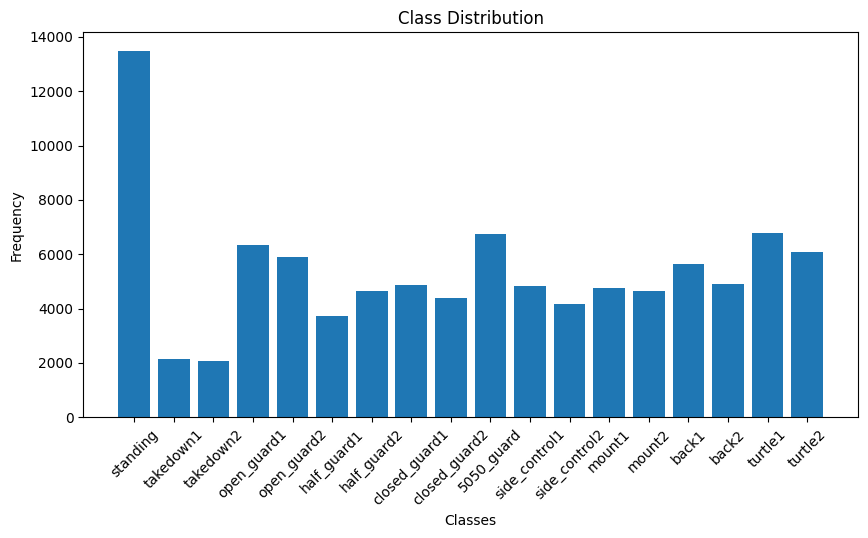

In [21]:
def plot_class_distribution(loader, classes):
    class_counts = np.zeros(len(classes))
    
    for _, _, labels in loader:
        for label in labels:
            class_counts[label.item()] += 1

    # Plot class distribution
    plt.figure(figsize=(10, 5))
    plt.bar(classes, class_counts)
    plt.xticks(rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Class Distribution')
    plt.show()

# Call the class distribution plotter
plot_class_distribution(train_iterator, classes)


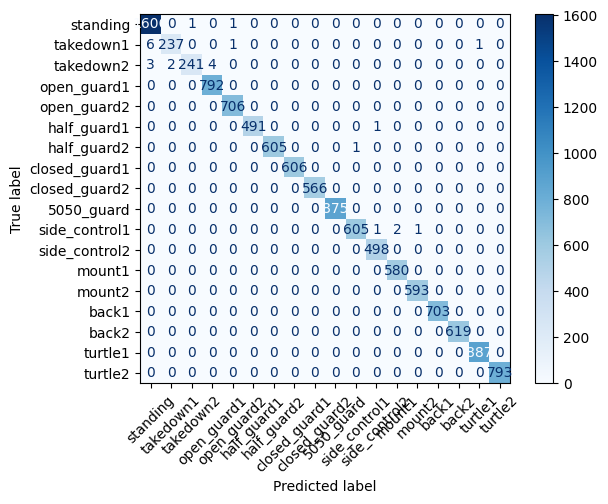

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, val_loader, classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, keypoints, labels in val_loader:
            images = images.to(device)
            keypoints = keypoints.to(device)
            labels = labels.to(device)

            outputs = model(images, keypoints)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.show()

plot_confusion_matrix(model, valid_iterator, classes)